In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import rasterio
from descartes import PolygonPatch
import lsmaker
from GISio import shp2df

% matplotlib inline
plt.rcParams['figure.figsize'] = 10, 10

In [2]:
# GFLOW model parameters for test case
solver_x0 = 671467.1 # origin of GFLOW solver coordinates in NAD 27 UTM 15
solver_y0 = 4997427.91
epsg = 26715 # projected coordinate system reference
inpath = '../test/input/'
dem = inpath + 'dem.tif' # dem for model area
clipto = inpath + 'testnearfield.shp' # extent for output rasters
grd = '../test/output/test.GRD' # Surfer GRD file from GFLOW solution
xtr = '../test/output/test.XTR' # Extract file from GFLOW solution
output_folder = 'temp' # folder for writing output rasters

# make the output folder if it doesn't exist
if not os.path.isdir(output_folder):
    os.makedirs(output_folder)
    
output_streamflow_shapefile = output_folder + '/streamflow.shp'

### make a shapefile of the streamflow results

In [3]:
lsmaker.utils.write_streamflow_shapefile(xtr, outshp=output_streamflow_shapefile, 
                                         solver_x0=solver_x0, solver_y0=solver_y0, epsg=epsg)

writing temp/streamflow.shp...


### read in and plot the streamflow

In [4]:
df = shp2df(output_streamflow_shapefile)
df.head()


reading temp/streamflow.shp...
--> building dataframe... (may take a while for large shapefiles)


,x1,y1,x2,y2,spec_head,calc_head,discharge,width,resistance,depth,baseflow,overland11,BC_pct_err,label,geometry
0,687767.261456,5.005139e+06,687666.619544,5.005053e+06,1457.01,1456.764,-6.366638,7.766733,0.3,3.0,0.0,0.0,0.042977,LS_000061_0101,"LINESTRING (687767.2614559999 5005139.240272, ..."
1,687666.619544,5.005053e+06,687582.238712,5.005071e+06,1457.01,1456.474,-13.887300,7.766733,0.3,3.0,0.0,0.0,0.042901,LS_000061_0201,"LINESTRING (687666.619544 5005053.399448, 6875..."
2,687582.238712,5.005071e+06,687634.670408,5.005190e+06,1457.00,1456.602,-10.304160,7.766711,0.3,3.0,0.0,0.0,0.043006,LS_000061_0301,"LINESTRING (687582.238712 5005071.269872, 6876..."
3,687634.670408,5.005190e+06,687768.261200,5.005140e+06,1457.00,1456.892,-2.787542,7.766711,0.3,3.0,0.0,0.0,0.043086,LS_000061_0401,"LINESTRING (687634.670408 5005189.699912, 6877..."
4,688403.589368,5.006317e+06,688378.269632,5.006088e+06,1463.90,1463.847,-1.363574,7.781718,0.3,3.0,0.0,0.0,0.044174,LS_000068_0101,"LINESTRING (688403.5893679999 5006316.649144, ..."



reading ../test/input/testnearfield.shp...
--> building dataframe... (may take a while for large shapefiles)


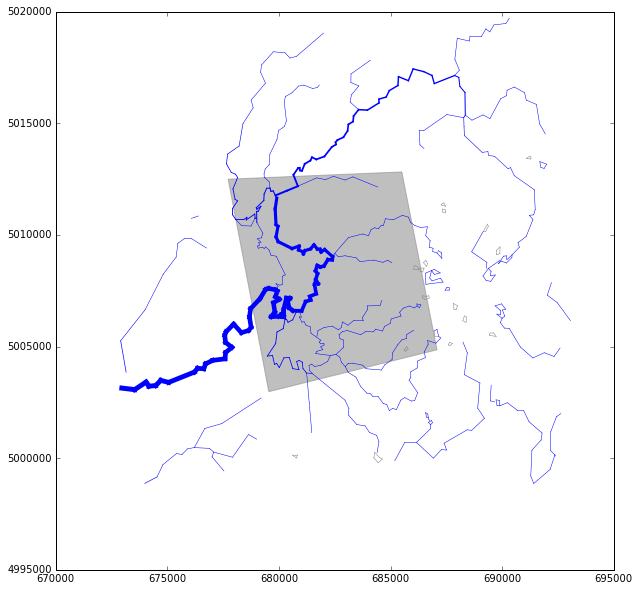

In [5]:
fig, ax = plt.subplots()
maxflow = df.baseflow.max()

def scale(baseflow, lw, min_lw=0.5):
    lw = lw * baseflow/maxflow
    return min_lw if lw < min_lw else lw

def color(baseflow, wet='b', dry='0.5'):
    return wet if baseflow > 0 else dry

# first plot clipto area where flooded heads will be plotted
cp = shp2df(clipto)
ptch = PolygonPatch(cp.geometry[0])
pc = PatchCollection([ptch], color='0.5', alpha=0.5, zorder=-1)
ax.add_collection(pc)

# plot the lines, scaled by baseflow
for i, r in df.iterrows():
    x, y = r.geometry.xy
    ax.plot(x, y, lw=scale(r.baseflow, 5), c=color(r.baseflow))

### Make a raster comparing simulated heads to a DEM  
* this can also be examined in a GIS with other data (wetland coverages, dem, etc.)

In [6]:
lsmaker.utils.plot_flooding(grd, dem=dem, epsg=epsg, clipto=clipto,
                                  outpath=output_folder,
                                  solver_x0=solver_x0, solver_y0=solver_y0, scale_xy=0.3048,
                                  dem_mult=1/.3048, resolution=(30, 30))

reading ../test/output/test.GRD...
wrote temp\heads_prj.tif.
reprojecting temp\heads_prj.tif from +init=epsg:26715, res: 1.47e+02, 1.17e+02
to epsg:26715, res: 3.00e+01, 3.00e+01...
wrote temp/tmp/heads_rs.tif.
reprojecting ../test/input/dem.tif from +init=epsg:4269, res: 9.26e-05, 9.26e-05
to epsg:26715, res: 3.00e+01, 3.00e+01...
wrote temp/tmp/dem_rs.tif.
clipping temp/tmp/dem_rs.tif...
wrote temp/tmp/dem_cp.tif
clipping temp/tmp/heads_rs.tif...
wrote temp/tmp/heads_cp.tif
wrote temp/dtw.tif
wrote temp/flooding.tif


C:\Users\aleaf\AppData\Local\Continuum\Anaconda3\lib\site-packages\rasterio\__init__.py:168: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


### Plot the gridded heads from GFLOW  
* GFLOW limits the resolution to 200 pixels on a side  
* the plot_flooding macro downsamples these to a specified x,y resolution (```resolution``` argument; default is (30, 30), so that information from the DEM is retained when comparing the rasters
* ```heads_prj``` is the projected, but unclipped heads

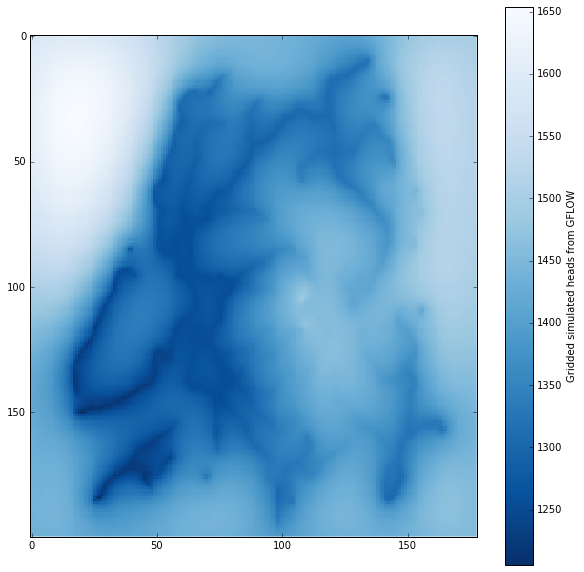

In [10]:
with rasterio.open('temp\heads_prj.tif') as rst:
    hds = rst.read()
    plt.imshow(hds[0, :, :], cmap='Blues_r', interpolation='none')
    plt.colorbar(label='Gridded simulated heads from GFLOW')

### Plot raster of simulated flooded heads  

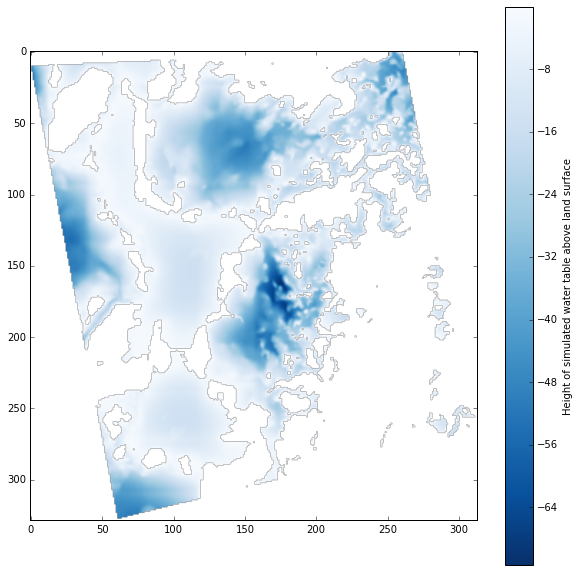

In [8]:
with rasterio.open('temp/flooding.tif') as rst:
    fld = rst.read()
    plt.imshow(fld[0, :, :], cmap='Blues_r')
    plt.colorbar(label='Height of simulated water table above land surface')

### Plot raster of simulated depth to groundwater

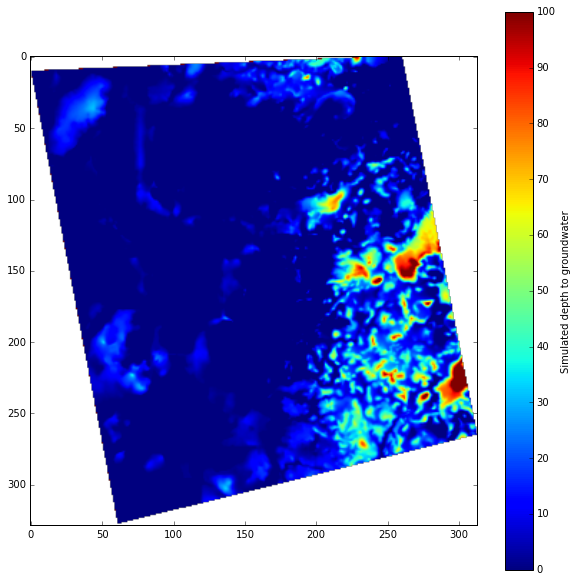

In [9]:
with rasterio.open('temp/dtw.tif') as rst:
    dtw = rst.read()
    plt.imshow(dtw[0, :, :], vmin=0, vmax=100)
    plt.colorbar(label='Simulated depth to groundwater')